**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# 1. Data Understanding
Defined the path for both train and test images from dataset.

In [1]:
# Importing Libraries

"""
Core libraries for handling directory and file paths, deep learning,
data processing, and visualization.
"""
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import random
from pathlib import Path
from google.colab import drive
import shutil

# TensorFlow Keras utilities for building and training models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout,
    Activation, Rescaling, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seeds for reproducibility
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

In [3]:
#mount google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Define paths
zip_path = "/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip"
unzip_dir = "/content/gdrive/MyDrive/Upgrad/CNN_assignment"

# Check if the directory exists
if os.path.exists(unzip_dir):
    print(f"Directory '{unzip_dir}' exists. Deleting it...")
    shutil.rmtree(unzip_dir)  # Remove the existing folder

# Unzip the file
print(f"Unzipping '{zip_path}' to '{unzip_dir}'...")
!unzip "$zip_path" -d "$unzip_dir"

# Verify the unzipped content
print("Unzipped content:")
!ls "$unzip_dir"

Directory '/content/gdrive/MyDrive/Upgrad/CNN_assignment' exists. Deleting it...
Unzipping '/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip' to '/content/gdrive/MyDrive/Upgrad/CNN_assignment'...
Archive:  /content/gdrive/MyDrive/Upgrad/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The Internation

In [5]:
# Define paths for train and test data
data_dir_train = pathlib.Path(unzip_dir) / "Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_dir_test = pathlib.Path(unzip_dir) / "Skin cancer ISIC The International Skin Imaging Collaboration/Test"

#

In [6]:
# Count the total number of images in the training dataset
image_count_train =  len(list(data_dir_train.glob('*/*.jpg')))
print("Total Number of Images in the Training Dataset:", image_count_train)

# Count the total number of images in the test dataset
image_count_test =  len(list(data_dir_test.glob('*/*.jpg')))
print("Total Number of Images in the Test Dataset:", image_count_test)

Total Number of Images in the Training Dataset: 2239
Total Number of Images in the Test Dataset: 118


# 2. Dataset Creation

-  Created train & validation dataset from the train directory with a batch size of 32.
-  Resized images to 180*180.(10%)

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# 3. Dataset Visualisation
Created a code to visualize one instance of all the nine classes present in the dataset.

In [10]:
# Retrieving the names of all the classes (skin cancer types)
class_names = train_ds.class_names

# Printing the list of class names to the console
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


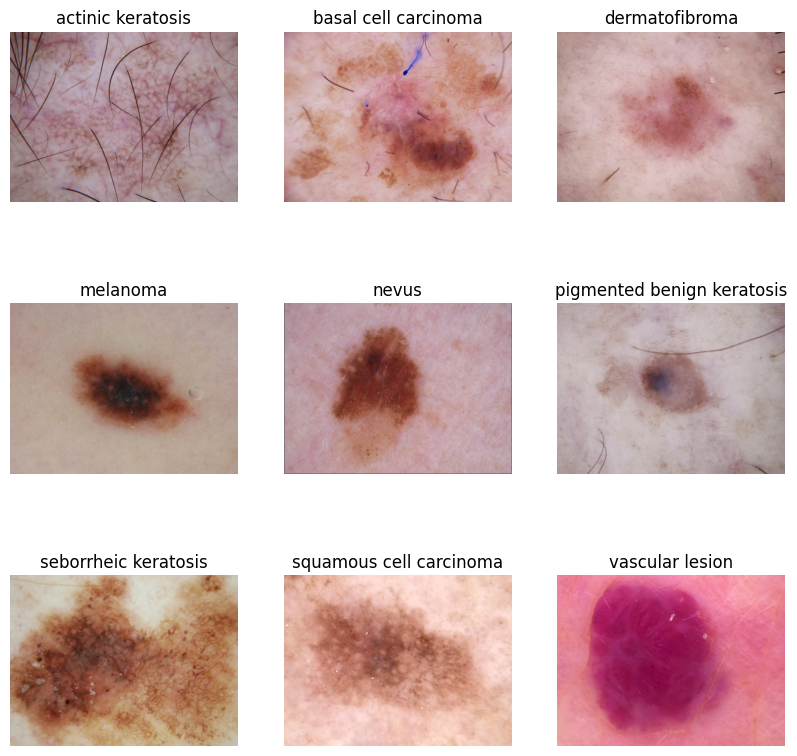

In [11]:
#  Visualizing one instance of all the nine classes present in the dataset

# Setting up the figure with a size of 10x10 for displaying images in a 3x3 grid
plt.figure(figsize=(10, 10))

# Looping through the first 9 classes to display one sample image from each
for i in range(9):
    # Creating a subplot for each image, arranging them in a 3x3 grid
    plt.subplot(3, 3, i + 1)

    # Loading an example image (second image in each class directory) based on class name
    image = plt.imread(str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))

    # Setting the title of each subplot to the corresponding class name
    plt.title(class_names[i])

    # Displaying the image in the subplot
    plt.imshow(image)

    # Turning off axis lines and labels for a cleaner display
    plt.axis('off')

# Rendering the final plot containing the grid of images
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
# Enable automatic prefetching for optimized data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the dataset to speed up the training process after the first epoch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply caching and prefetching to the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Model-1 Building & Training

* Created a CNN model, which can accurately detect 9 classes present in the dataset.
* Defined appropriate optimiser and loss function for model training.
* Trained the model for ~20 epochs.
* Explained the findings after the model fit with evidence if the model overfits or underfits.
* Used layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1].1].

In [13]:
# Building a Sequential Model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

### Compiling the model

In [14]:
# Compiling the model
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
# Displaying the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [15]:
# Train the model
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.1741 - loss: 3.8984 - val_accuracy: 0.3221 - val_loss: 1.9081
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3633 - loss: 1.7899 - val_accuracy: 0.5190 - val_loss: 1.5309
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4922 - loss: 1.4670 - val_accuracy: 0.5213 - val_loss: 1.4278
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5285 - loss: 1.3303 - val_accuracy: 0.5369 - val_loss: 1.4330
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5800 - loss: 1.2280 - val_accuracy: 0.5481 - val_loss: 1.3599
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6593 - loss: 1.0262 - val_accuracy: 0.5459 - val_loss: 1.3800
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6911 - loss: 0.9249 - val_accuracy: 0.5570 - val_loss: 1.4576
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7097 - loss: 0.7901 - val_accuracy: 0.5436 -

### Visualizing training results

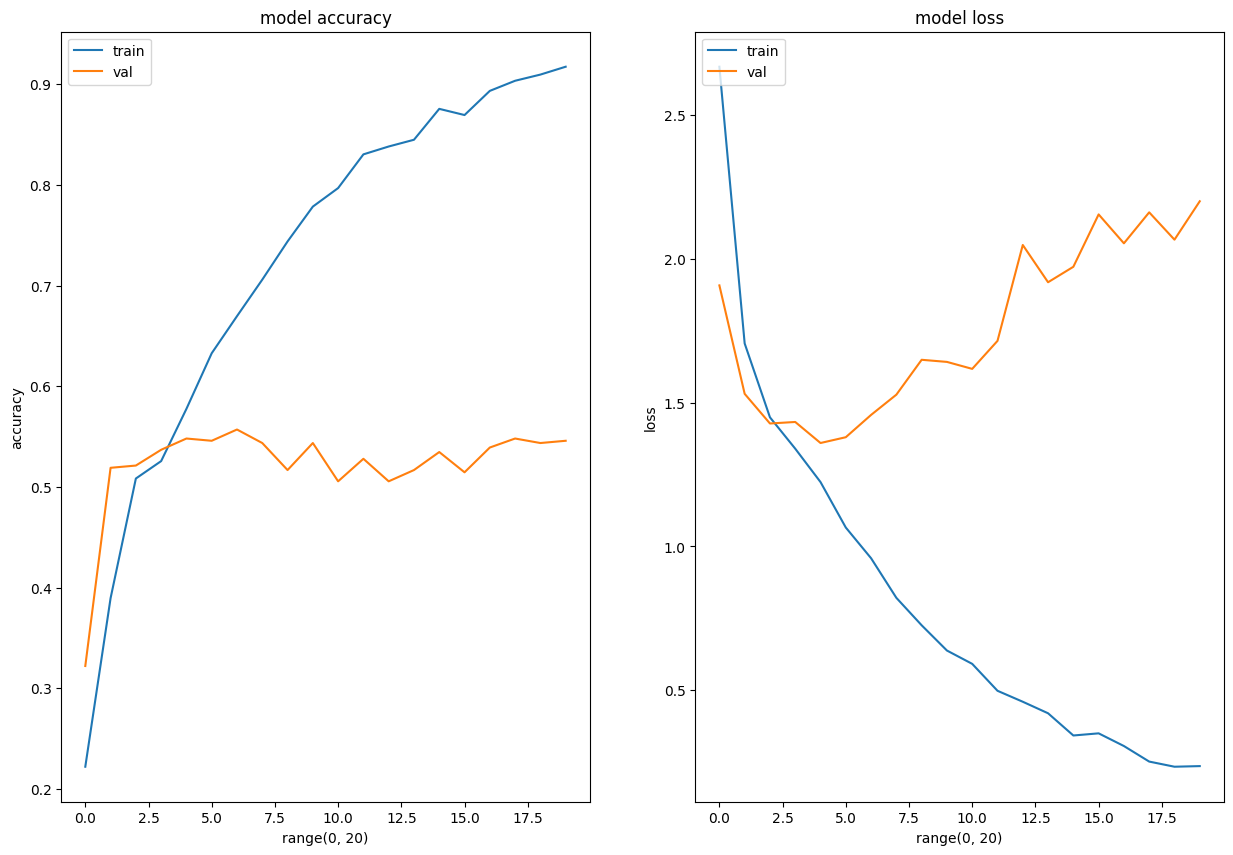

In [16]:
# Plot the training curves

epochs_range = range(epochs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# Evaluate the model's performance on the training dataset
loss, accuracy = model.evaluate(train_ds, verbose=1)

# Evaluate the model's performance on the validation dataset
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

# Print the training accuracy
print("Training Accuracy: ", accuracy)

# Print the validation accuracy to check how well the model performs on the validation data
print("Validation Accuracy: ", accuracy_v)

# Print the training loss
print("Training Loss: ", loss)

# Print the validation loss to check if there's overfitting or underfitting
print("Validation Loss: ", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9340 - loss: 0.1701
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5419 - loss: 2.0713
Training Accuracy:  0.9380580186843872
Validation Accuracy:  0.5458613038063049
Training Loss:  0.16367550194263458
Validation Loss:  2.2007386684417725


**Observation:**
-  The model shows signs of overfitting, evident from the high training accuracy (0.93) compared to the much lower validation accuracy (0.54).
-  The significant gap between the training loss and validation loss indicates the model struggles to generalize well to unseen data.
-  To address overfitting, we will apply data augmentation techniques. By generating new training samples through transformations like flipping, rotating, or zooming images, we can improve the model's generalization and reduce reliance on the limited training data.

# 5. Data Augmentation
Chose an appropriate data augmentation strategy to resolve underfitting/overfitting.

In [18]:
data_augmentation = keras.Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

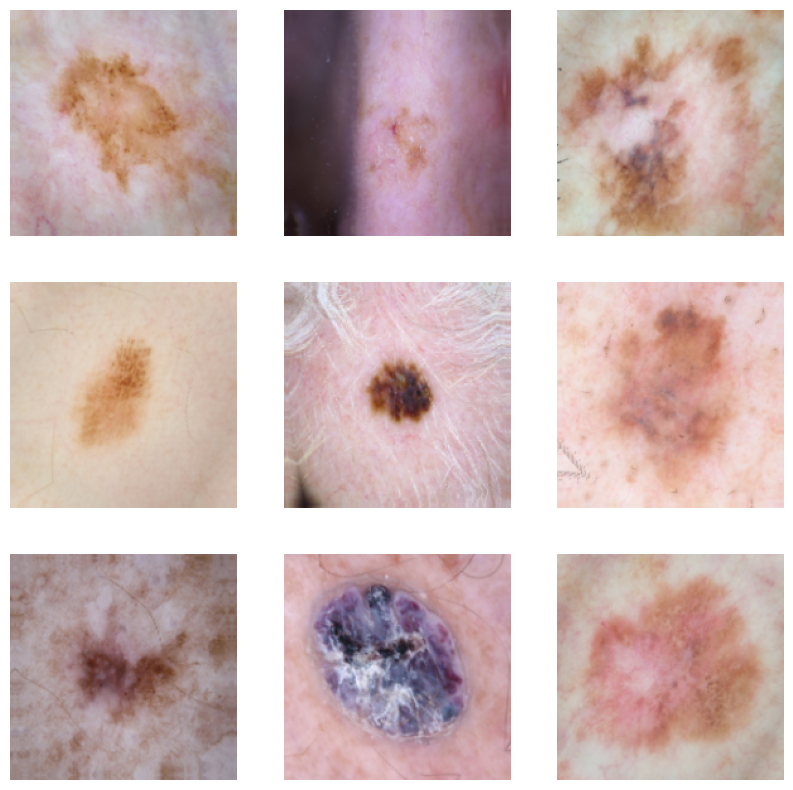

In [19]:
plt.figure(figsize=(10, 10))
# Iterate through a batch of images from the train_ds
for images, labels in train_ds:
    for i in range(9):  # Display the first 9 augmented images
        augmented_image = data_augmentation(images[i:i+1])  # Augment one image at a time
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
    break  # Only take the first batch of images

# 6. Model-2 Building & Training

* Created a CNN model, which can accurately detect 9 classes present in the dataset.
* Defined appropriate optimiser and loss function for model training.
* Trained the model for ~20 epochs.
* Explained the findings after the model fit with evidence if the earlier issue is resolved or not.ot.

In [20]:
# Building a Sequential Model
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

### Compiling the model

In [21]:
# Building and Compiling the model
model.build(input_shape=(None, img_height, img_width, 3))
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
# Displaying the model's architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [22]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1633 - loss: 4.8080 - val_accuracy: 0.2394 - val_loss: 1.9382
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3149 - loss: 1.8843 - val_accuracy: 0.4161 - val_loss: 1.6839
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4632 - loss: 1.5517 - val_accuracy: 0.4810 - val_loss: 1.5037
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4556 - loss: 1.4960 - val_accuracy: 0.4966 - val_loss: 1.4607
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5051 - loss: 1.4583 - val_accuracy: 0.5190 - val_loss: 1.4190
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5361 - loss: 1.3419 - val_accuracy: 0.4989 - val_loss: 1.4017
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5220 - loss: 1.3606 - val_accuracy: 0.5257 - val_loss: 1.3417
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5485 - loss: 1.2919 - val_accuracy: 0.5459 - v

### Visualizing the results

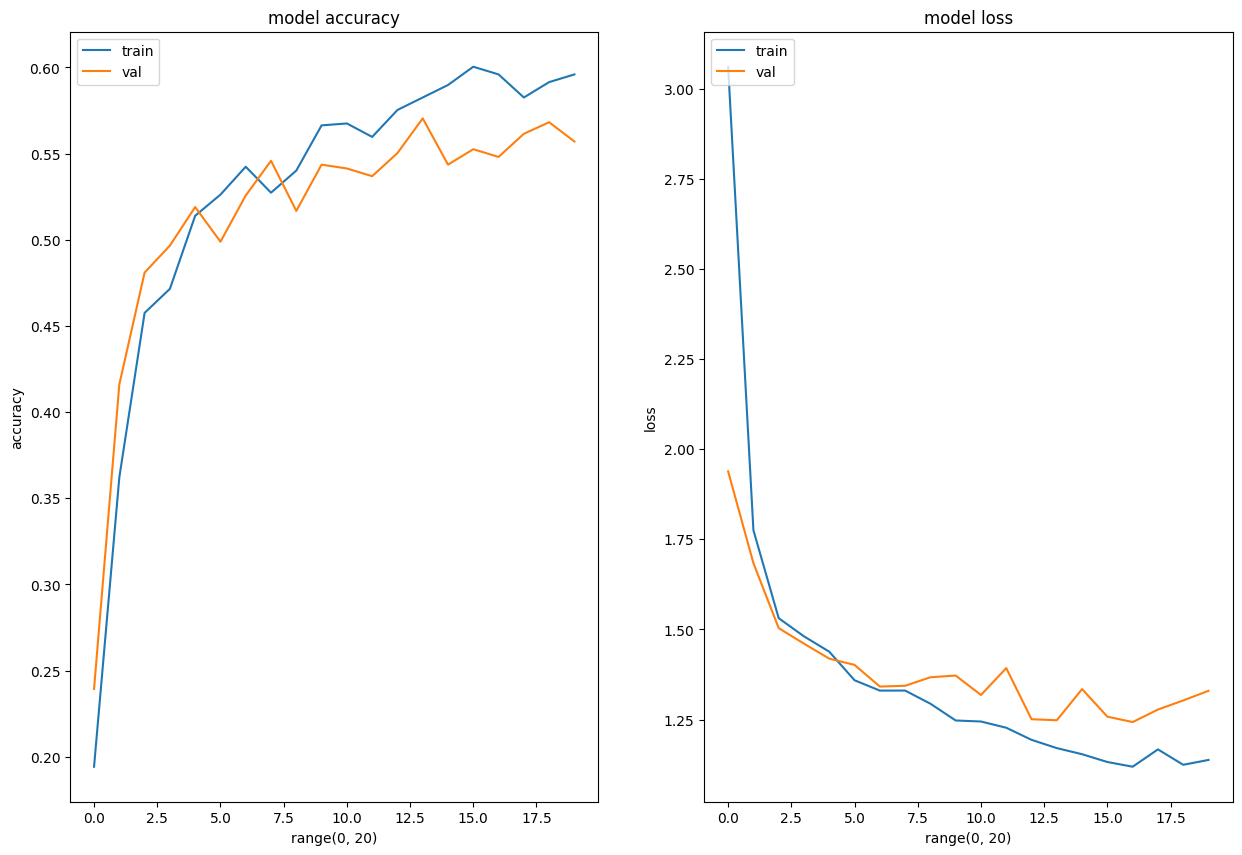

In [23]:
# Plot the training curves

epochs_range = range(epochs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# Evaluate the model's performance on the training dataset
loss, accuracy = model.evaluate(train_ds, verbose=1)

# Evaluate the model's performance on the validation dataset
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

# Print the training accuracy
print("Training Accuracy: ", accuracy)

# Print the validation accuracy to check how well the model performs on the validation data
print("Validation Accuracy: ", accuracy_v)

# Print the training loss
print("Training Loss: ", loss)

# Print the validation loss to check if there's overfitting or underfitting
print("Validation Loss: ", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6026 - loss: 1.0949
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5696 - loss: 1.2660
Training Accuracy:  0.6065848469734192
Validation Accuracy:  0.5570470094680786
Training Loss:  1.084913730621338
Validation Loss:  1.3299016952514648


**Observation:**
- With the help of augmented data, the problem of overfitting is mitigated.
- Training and validation accuracy of the above model are in the same range.
- The model is performing poorly both on training data and validation data- i.e. the model is underfitting now.

# 7. Class distribution

* Examined the current class distribution in the training dataset.
* Explained the following:
    * Which class has the least number of samples?
    * Which classes dominate the data in terms of the proportionate number of samples?

                        Class  No. of images
6        seborrheic keratosis             77
2              dermatofibroma             95
0           actinic keratosis            114
8             vascular lesion            139
7     squamous cell carcinoma            181
4                       nevus            357
1        basal cell carcinoma            376
3                    melanoma            438
5  pigmented benign keratosis            462


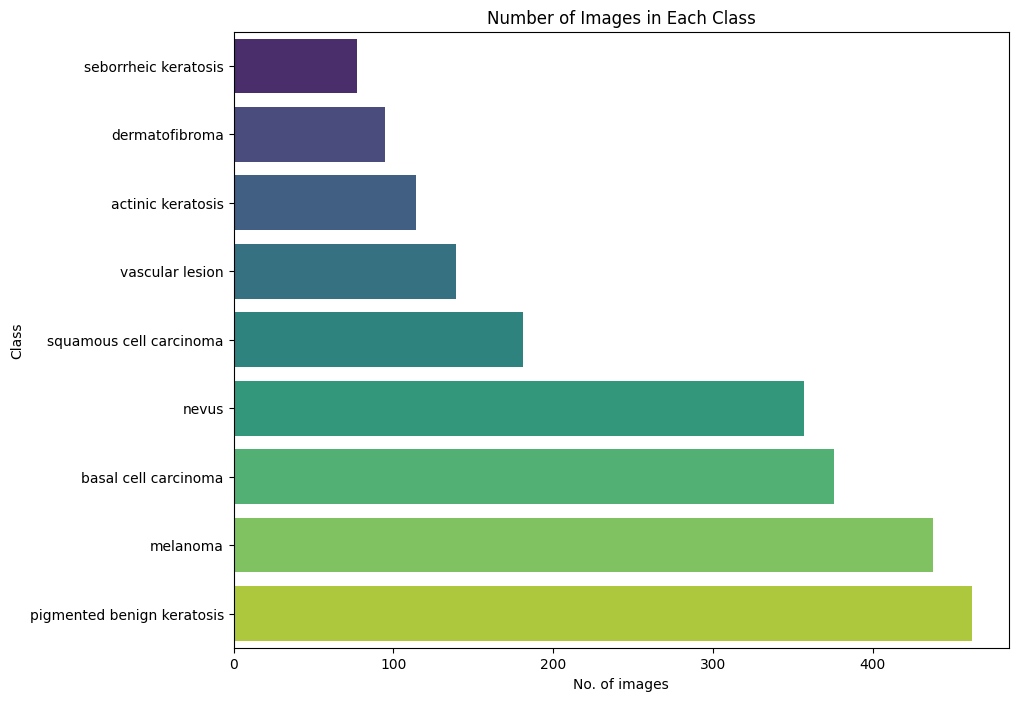

In [25]:
# Function to count images in each class directory
def class_distribution_count(directory):
  classes, counts=[], []

  for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
      classes.append(path.name)
      counts.append(len([f for f in path.iterdir() if f.is_file()]))

  # Returning a sorted Dataframe
  return pd.DataFrame({'Class':classes,'No. of images': counts}).sort_values(by='No. of images')

# Calling the function and storing the result
class_distribution_df = class_distribution_count(data_dir_train)
print(class_distribution_df)

# Plotting the class distribution
plt.figure(figsize=(10,8))
sns.barplot(x='No. of images',y='Class',data=class_distribution_df,hue='Class',palette='viridis')
plt.title("Number of Images in Each Class")
plt.legend([], [], frameon=False)
plt.show()

# 8. Handling Class Imbalance
Rectified class imbalances present in the training dataset with Augmentor library.

In [26]:
# Create a list of file paths for all `.jpg` images in the training data directory (including subdirectories)
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

# Extract the class (folder name) for each image by getting the directory name containing the image file
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

# Print the total number of images (length of the lesion_list, which corresponds to the number of image labels)
print(len(lesion_list))

2239


In [27]:
# Create a dictionary that maps image file paths to their corresponding class labels
df_dict_original = dict(zip(path_list, lesion_list))

# Print the first two items in the dictionary as a sample output
print(list(df_dict_original.items())[:2])

[('/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', 'actinic keratosis'), ('/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis')]


In [28]:
# Convert the dictionary into a DataFrame
# The dictionary keys (image paths) become the first column, and values (labels) become the second column
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path', 'Label'])

# Display the first five rows of the DataFrame for inspection
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis


In [29]:
# Count the occurrences of each unique label in the 'Label' column
original_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [30]:
# Calculate the proportion of each unique label in the 'Label' column
original_df[['Label']].value_counts(normalize=True)

,proportion
Label,
pigmented benign keratosis,0.206342
melanoma,0.195623
basal cell carcinoma,0.167932
nevus,0.159446
squamous cell carcinoma,0.080840
vascular lesion,0.062081
actinic keratosis,0.050916
dermatofibroma,0.042430
seborrheic keratosis,0.034390


#### - Which class has the least number of samples?
- 'seborrheic keratosis' has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
- the classes 'pigmented benign keratosis' and 'melanoma' dominate the data with 20.6% and 19.5% samples respectively.

In [31]:
# Install Augmentor Library
!pip install -q Augmentor

In [32]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B8C050FFD0>: 100%|██████████| 500/500 [00:30<00:00, 16.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B8C05799C0>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B8C0593D30>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x78B8C05AA290>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B8CC3C3EE0>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B8C0606440>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78B8C052ACB0>: 100%|██████████| 500/500 [00:46<00:00, 10.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B8CC20DD50>: 100%|██████████| 500/500 [00:26<00:00, 18.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B8CC2A4040>: 100%|██████████| 500/500 [00:25<00:00, 19.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Distribution of augmented data after adding new images to the original training data.

In [34]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_4bb329c4-125f-40ec-9e39-b1e1731b030e.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_90d9cc33-c686-41ae-bfc6-54618e9309d1.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_db4efe94-4a9c-4380-b5b7-9fda3d439bff.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_d3e7d158-531b-462d-a2f8-57fa27e36d97.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin 

In [35]:
# Get the paths of all .jpg images in the subdirectories of the training data directory
image_paths = glob(os.path.join(data_dir_train, '*', '*.jpg'))

# Create a list of class labels (lesions) by extracting the name of the parent directory for each image path
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Display the first two class labels for verification
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [36]:
# Create a dictionary where the keys are the image file paths and the values are the corresponding class labels (lesions)
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
# Convert the dictionary of image paths and labels into a DataFrame with columns 'Path' and 'Label'
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path', 'Label'])

# Concatenate the new DataFrame (df2) with the original DataFrame (original_df)
# The ignore_index=True ensures that the index is reset and does not retain the original indices
new_df = pd.concat([original_df, df2], ignore_index=True)

# Display the shape (number of rows and columns) of the combined DataFrame
new_df.shape

(6739, 2)

In [38]:
# Display the first five rows of the new DataFrame (new_df) to inspect the data
new_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/CNN_assignment/...,actinic keratosis


In [39]:
# Checking the class distribution after adding 500 samples per label
new_df['Label'].value_counts(normalize=True)

,proportion
Label,
pigmented benign keratosis,0.142751
melanoma,0.139190
basal cell carcinoma,0.129990
nevus,0.127170
squamous cell carcinoma,0.101054
vascular lesion,0.094821
actinic keratosis,0.091111
dermatofibroma,0.088292
seborrheic keratosis,0.085621


In [40]:
# Checking the class distribution after adding 500 samples per label (actual counts)
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# 9. Model-3  Building & Training
-  Created a CNN model, which can accurately detect 9 classes present in the dataset.
-  Defined appropriate optimiser and loss function for model training.
-  Trained the model for 30 epochs.
-  Explained the findings after the model fit with evidence if the issues are resolved or not.

### Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [42]:
# Creating a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [43]:
# Creating a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (With BatchNormalization)

In [44]:
# Building a Sequential Model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3),
                 kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu',
                 kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding='same', activation='relu',
                 kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(128, 3, padding='same', activation='relu',
                 kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

### Compiling the model


In [45]:
# Build and compile the model
model.build((None, 180, 180, 3))
# Optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,082,153 (7.94 MB)

 Trainable params: 2,081,673 (7.94 MB)

 Non-trainable params: 480 (1.88 KB)

### Training the model

In [46]:
# Train the model
# Adding Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
epochs = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    shuffle=True,
                    callbacks=[early_stopping,lr_scheduler]
                   )

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 289ms/step - accuracy: 0.2310 - loss: 2.9555 - val_accuracy: 0.1403 - val_loss: 6.6394 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 285ms/step - accuracy: 0.3694 - loss: 1.7120 - val_accuracy: 0.2509 - val_loss: 4.8615 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.4443 - loss: 1.5468 - val_accuracy: 0.4722 - val_loss: 1.7385 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4991 - loss: 1.3806 - val_accuracy: 0.6080 - val_loss: 1.1214 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 324ms/step - accuracy: 0.5544 - loss: 1.2429 - val_accuracy: 0.6488 - val_loss: 1.0537 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.5721 - loss: 1.2034 - val_accuracy: 0.6860 - val_loss: 0.9188 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 31

####  Visualize the model results

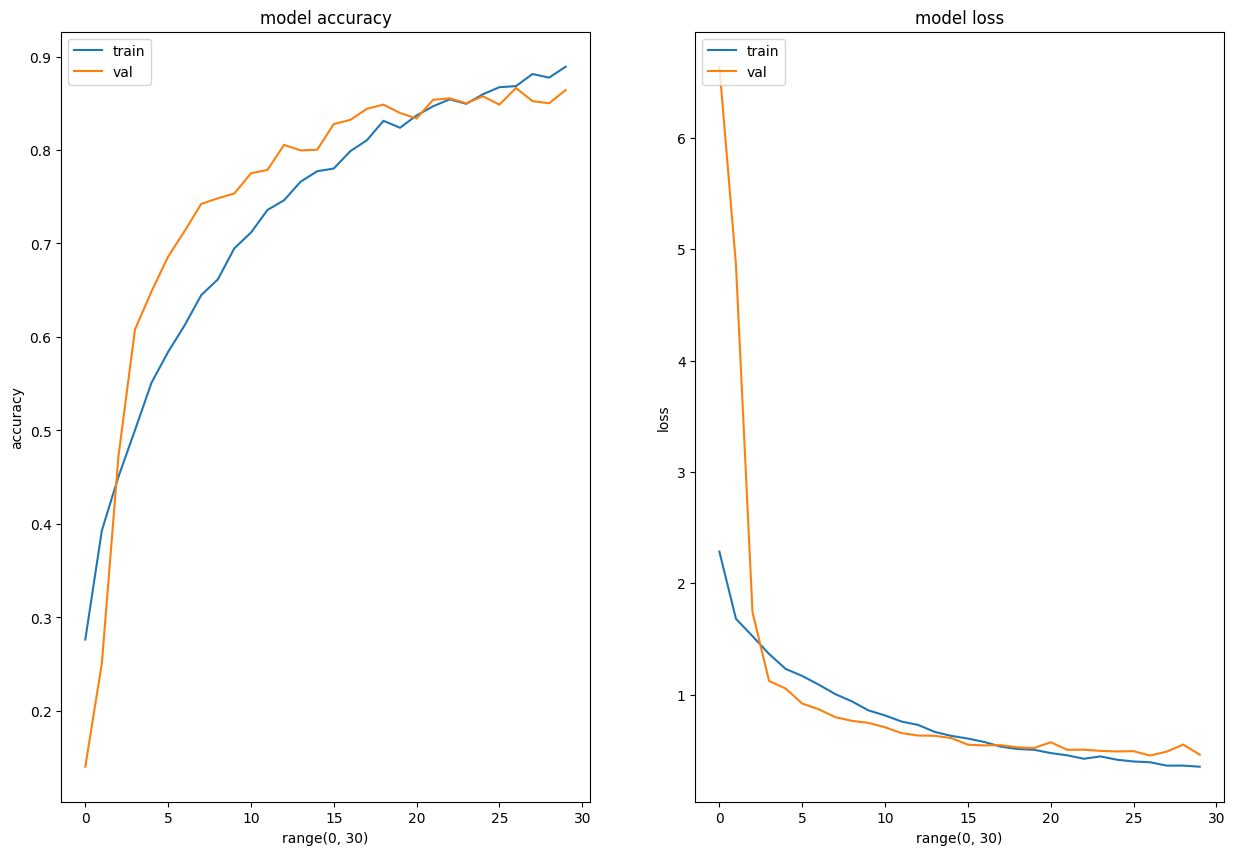

In [47]:
# Plot the training curves

epochs_range = range(epochs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Evaluate the model's performance on the training dataset
loss, accuracy = model.evaluate(train_ds, verbose=1)

# Evaluate the model's performance on the validation dataset
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

# Print the training accuracy
print("Training Accuracy: ", accuracy)

# Print the validation accuracy to check how well the model performs on the validation data
print("Validation Accuracy: ", accuracy_v)

# Print the training loss
print("Training Loss: ", loss)

# Print the validation loss to check if there's overfitting or underfitting
print("Validation Loss: ", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.9561 - loss: 0.1614
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.8685 - loss: 0.4538
Training Accuracy:  0.9606825113296509
Validation Accuracy:  0.8663697242736816
Training Loss:  0.15367500483989716
Validation Loss:  0.45195192098617554


#### Did you get rid of underfitting/overfitting? Did class rebalance help?

### **Observation:**
-  The final model is not overfitting and is generalizing well.
-  The performance has improved on both training and validation data after applying class rebalancing.
-  Over 30 epochs, the model achieved 96% training accuracy and 86% validation accuracy.
-  The small gap between training and validation accuracy indicates that the model generalizes well.
-  The final model incorporates L2 regularization (e.g., kernel_regularizer=l2(0.0001)) to prevent overfitting by penalizing large weights.
-  The final model uses BatchNormalization after each convolutional layer, which stabilizes training and speeds up convergence.
-  Added two more convolutional layers (64 and 128 filters) to increase the network's capacity, enabling it to learn more complex features.
-  The final model includes Dropout layers (0.5 rate), reducing overfitting by randomly deactivating neurons during training.
-  The final model uses a learning rate scheduler (ReduceLROnPlateau) and a lower learning rate (0.0001), helping the model converge more smoothly.
-  EarlyStopping is implemented in the final model to prevent overfitting by stopping training if validation loss doesn't improve for several epochs, and it restores the best weights.